In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = []
with open('local-results.jsonl') as f:
    for line in f:
        if line.strip():
            data.append(json.loads(line))

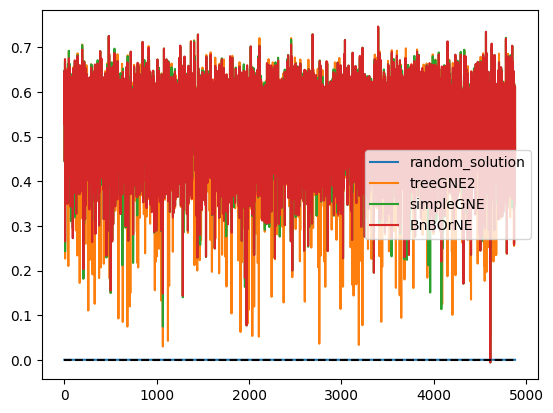

In [3]:
# Create a line chart of the reward for each algorithm at each iteration
algorithms = [
    'random_solution',
    # 'treeGNE', 
    'treeGNE2', 
    # 'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
for algorithm in algorithms:
    array = []
    for d in data:
        upper_bound = d['upper_bound']
        array.append(d[algorithm]['reward'] / upper_bound - d['random_solution']['reward'] / upper_bound)
    plt.plot(array)
plt.legend(algorithms)

# Draw a y=0 line
plt.plot([0, len(data)], [0, 0], 'k--')

In [4]:
all_algorithms = [
    'random_solution',
    'treeGNE', 
    'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    'AOsearchGNE', 
    'OrNE', 
    'BnBOrNE', 
    'BnBOrNEskip'
]

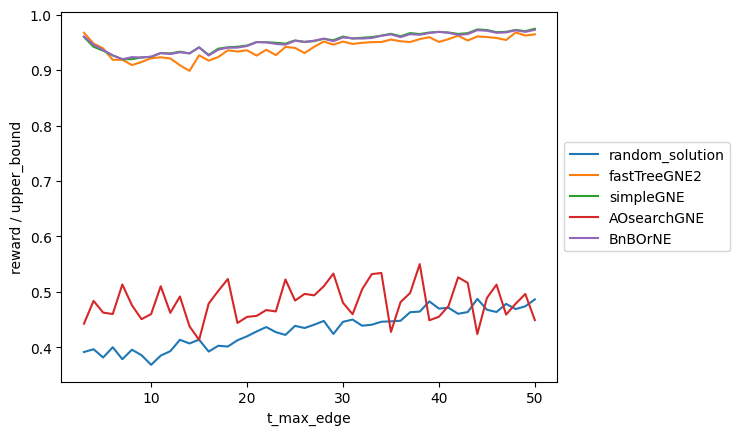

In [5]:

algorithms = [
    'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]


all_rewards = {}
for d in data:
    t_max_edge = d['info']['t_max_edge']
    upper_bound = d['upper_bound']
    for algorithm in algorithms:
        all_rewards[algorithm] = all_rewards.get(algorithm, {})
        all_rewards[algorithm][t_max_edge] = all_rewards[algorithm].get(t_max_edge, [])
        all_rewards[algorithm][t_max_edge].append(d[algorithm]['reward'] / upper_bound)

for t_max_edge, array in all_rewards.items():
    for algorithm, arr in array.items():
        array[algorithm] = np.mean(arr)

for algorithm, array in all_rewards.items():
    plt.plot(list(array.keys()), list(array.values()), label=algorithm)
plt.legend()
plt.xlabel('t_max_edge')
plt.ylabel('reward / upper_bound')


# Put the legend to the right of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


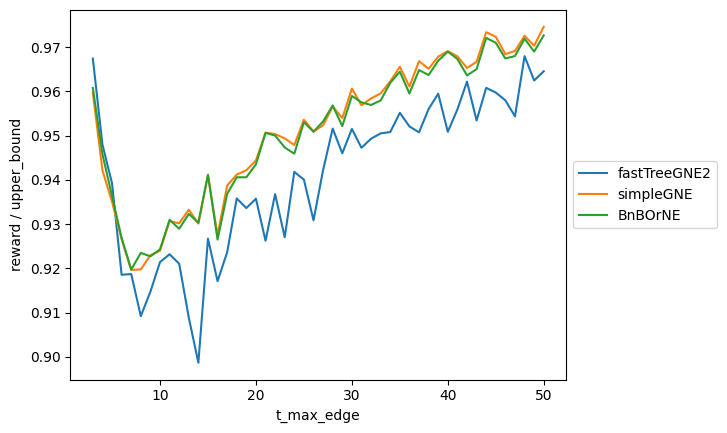

In [6]:

algorithms = [
    # 'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]


all_rewards = {}
for d in data:
    t_max_edge = d['info']['t_max_edge']
    upper_bound = d['upper_bound']
    for algorithm in algorithms:
        all_rewards[algorithm] = all_rewards.get(algorithm, {})
        all_rewards[algorithm][t_max_edge] = all_rewards[algorithm].get(t_max_edge, [])
        all_rewards[algorithm][t_max_edge].append(d[algorithm]['reward'] / upper_bound)

for t_max_edge, array in all_rewards.items():
    for algorithm, arr in array.items():
        array[algorithm] = np.mean(arr)

for algorithm, array in all_rewards.items():
    plt.plot(list(array.keys()), list(array.values()), label=algorithm)
plt.legend()
plt.xlabel('t_max_edge')
plt.ylabel('reward / upper_bound')


# Put the legend to the right of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


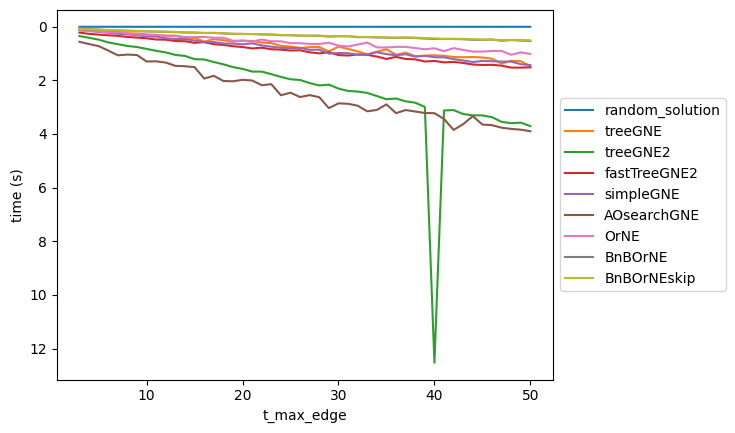

In [7]:
all_time = {}
for d in data:
    t_max_edge = d['info']['t_max_edge']
    for algorithm in all_algorithms:
        all_time[algorithm] = all_time.get(algorithm, {})
        all_time[algorithm][t_max_edge] = all_time[algorithm].get(t_max_edge, [])
        all_time[algorithm][t_max_edge].append(d[algorithm]['time'])

for t_max_edge, array in all_time.items():
    for algorithm, arr in array.items():
        array[algorithm] = np.mean(arr)

for algorithm, array in all_time.items():
    plt.plot(list(array.keys()), list(array.values()), label=algorithm)
plt.legend()
plt.xlabel('t_max_edge')
plt.ylabel('time (s)')

# Put the legend to the right of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Flip the y-axis
plt.gca().invert_yaxis()

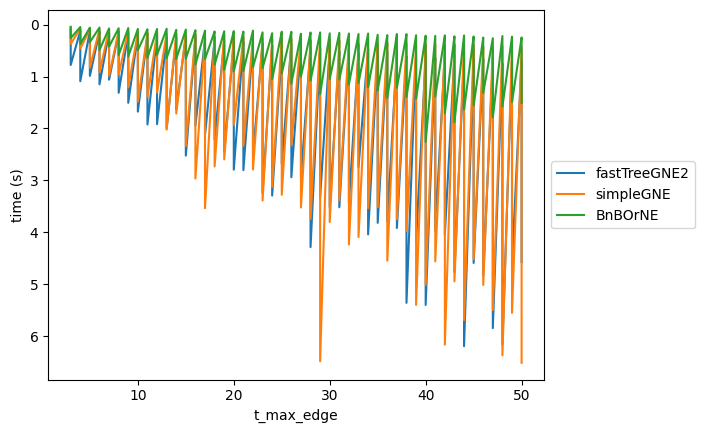

In [8]:
all_time = {}
for d in data:
    t_max_edge = d['info']['t_max_edge']
    for algorithm in algorithms:
        all_time[algorithm] = all_time.get(algorithm, [])
        all_time[algorithm].append({
            't_max_edge': t_max_edge,
            'time': d[algorithm]['time']
        })

for algorithm, array in all_time.items():
    array = sorted(array, key=lambda x: (x['t_max_edge'], x['time']))
    plt.plot([x['t_max_edge'] for x in array], [x['time'] for x in array], label=algorithm)

plt.legend()
plt.xlabel('t_max_edge')
plt.ylabel('time (s)')

# Put the legend to the right of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Flip the y-axis
plt.gca().invert_yaxis()